# Modelling Trust for Germany

In [1]:
import pandas as pd

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/wvs/wave7.csv')

# Define the list of countries to include
countries_to_keep = ['DEU']
# Filter the DataFrame
df = df[df['B_COUNTRY_ALPHA'].isin(countries_to_keep)].copy()

C:\Users\ekaba\AppData\Local\Temp\ipykernel_15992\597167731.py:1: DtypeWarning: Columns (582,583,584) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wvs/wave7.csv')


# Baseline distrust

In [21]:
X = df.loc[:, 'baseline_corruption':]
y = df['base_distrust_index']

### Train LASSO for feature selection, we only use features in OLS that are non-zero in LASSO

Best alpha: 0.00031668743650185946
Lasso coefficients:
 baseline_corruption           0.001165
group_corruption              0.043406
migration_perception         -0.106616
migration_positive           -0.006820
migration_negative           -0.010896
pol_pref                      0.032910
gender                        0.006787
age                          -0.001139
mother_immigrant             -0.000000
father_immigrant              0.000000
is_immigrant                  0.004587
standard_parents_better      -0.007424
standard_parents_worse        0.010202
baseline_happiness           -0.021774
health                       -0.044708
freedom                      -0.027495
baseline_satisfaction        -0.056889
financial_satisfaction       -0.000000
hardships_questions           0.000000
security_actions_money_no    -0.005093
security_actions_night_no    -0.018770
security_actions_weapon_no   -0.021488
victim_respondent_no          0.014985
victim_family_no              0.000000
war_no  

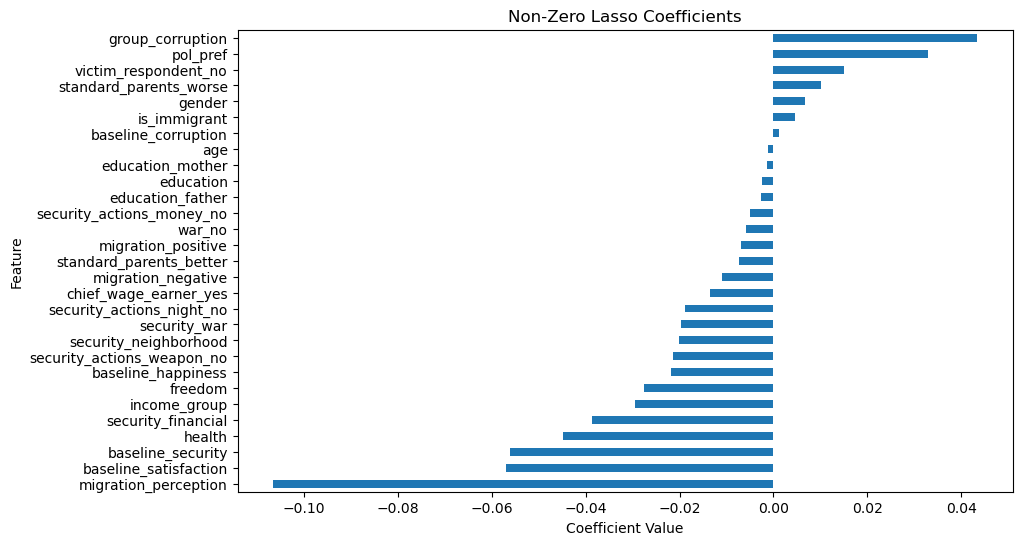

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run LassoCV to find best alpha
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Coefficients
lasso_coefficients = pd.Series(lasso_cv.coef_, index=X.columns)
print("Lasso coefficients:\n", lasso_coefficients)

# R^2 Scores
print(f"Training R^2: {lasso_cv.score(X_train, y_train):.3f}")
print(f"Test R^2: {lasso_cv.score(X_test, y_test):.3f}")

# Plot non-zero coefficients
nonzero_coeffs = lasso_coefficients[lasso_coefficients != 0]
nonzero_coeffs.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Non-Zero Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


### OLS for inference

In [23]:
# Get the names of features with non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
X_ols = X[selected_features]

# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X_ols)

# Fit the OLS model
ols_model = sm.OLS(y, X_const).fit()

# Generate the regression table
print(ols_model.summary())

                             OLS Regression Results                            
Dep. Variable:     base_distrust_index   R-squared:                       0.265
Model:                             OLS   Adj. R-squared:                  0.250
Method:                  Least Squares   F-statistic:                     18.14
Date:                  Mi, 15 Jan 2025   Prob (F-statistic):           1.10e-77
Time:                         20:06:59   Log-Likelihood:                 1175.4
No. Observations:                 1490   AIC:                            -2291.
Df Residuals:                     1460   BIC:                            -2132.
Df Model:                           29                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

In [24]:
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif)


                      Variable         VIF
0                        const  188.132995
1          baseline_corruption    1.421231
2             group_corruption    1.374378
3         migration_perception    1.337392
4           migration_positive    1.227913
5           migration_negative    1.247841
6                     pol_pref    1.140952
7                       gender    1.420181
8                          age    1.717311
9                 is_immigrant    1.190714
10     standard_parents_better    1.319661
11      standard_parents_worse    1.327684
12          baseline_happiness    1.547790
13                      health    1.366925
14                     freedom    1.228188
15       baseline_satisfaction    1.748926
16   security_actions_money_no    1.190139
17   security_actions_night_no    1.358900
18  security_actions_weapon_no    1.061627
19        victim_respondent_no    1.064640
20                      war_no    1.092818
21           baseline_security    1.424599
22       se

### Check residuals for assumptions

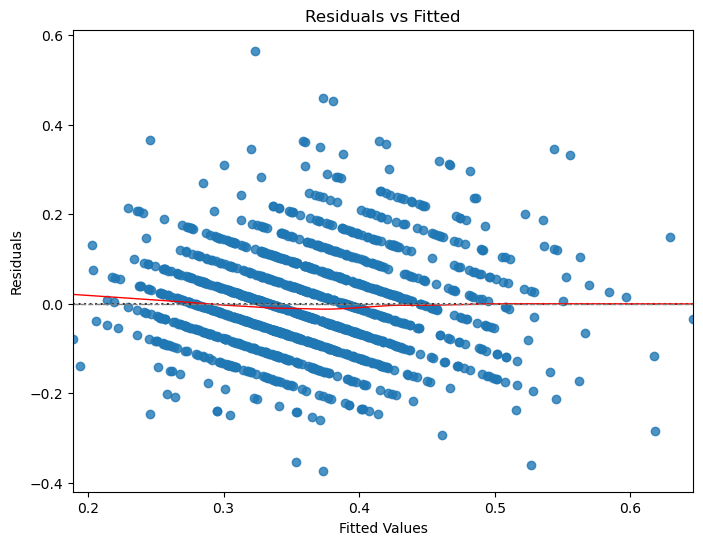

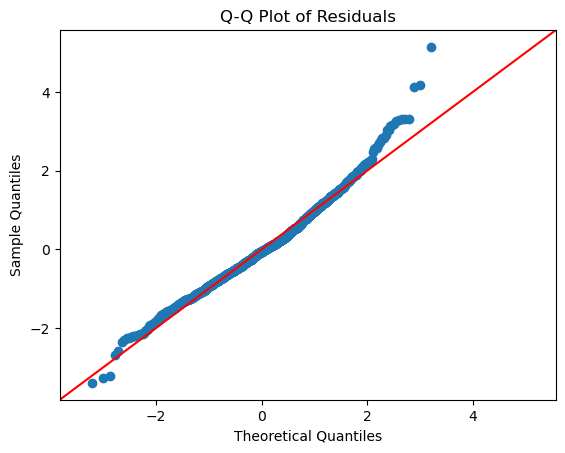

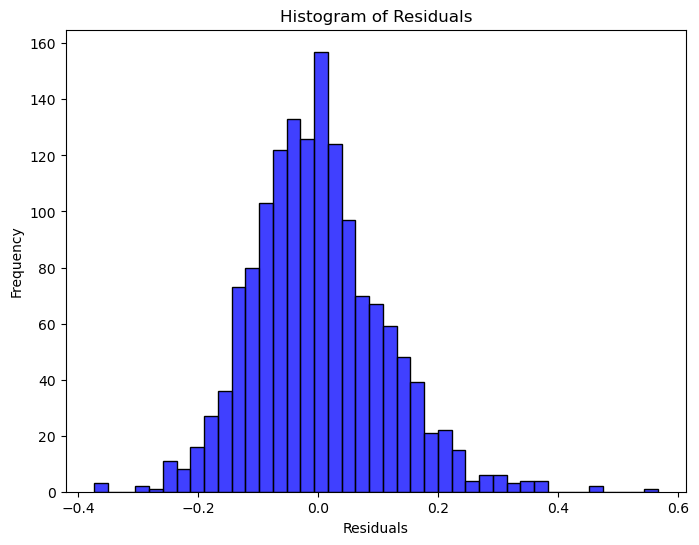

In [25]:
# Residuals from the model
residuals = ols_model.resid

# Predicted values from the model
fitted_values = ols_model.fittedvalues

# 1. Residuals vs. Fitted Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Normality seems fine, but heteroskedasticity might be a problem

### Robust standard errors

In [26]:
# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                             OLS Regression Results                            
Dep. Variable:     base_distrust_index   R-squared:                       0.265
Model:                             OLS   Adj. R-squared:                  0.250
Method:                  Least Squares   F-statistic:                     16.73
Date:                  Mi, 15 Jan 2025   Prob (F-statistic):           1.95e-71
Time:                         20:07:10   Log-Likelihood:                 1175.4
No. Observations:                 1490   AIC:                            -2291.
Df Residuals:                     1460   BIC:                            -2132.
Df Model:                           29                                         
Covariance Type:                   HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

# National distrust

In [12]:
X = df.loc[:, 'baseline_corruption':]
y = df['national_distrust_index']

### LASSO Feature Selection

Best alpha: 0.0003430654421389047
Lasso coefficients:
 baseline_corruption           0.088983
group_corruption              0.248866
migration_perception         -0.103580
migration_positive           -0.000000
migration_negative           -0.000000
pol_pref                      0.014175
gender                        0.004386
age                          -0.000466
mother_immigrant             -0.015585
father_immigrant              0.000000
is_immigrant                  0.001154
standard_parents_better      -0.010198
standard_parents_worse        0.009220
baseline_happiness           -0.013348
health                       -0.045783
freedom                      -0.011377
baseline_satisfaction        -0.007833
financial_satisfaction       -0.008881
hardships_questions           0.000000
security_actions_money_no    -0.007141
security_actions_night_no    -0.001035
security_actions_weapon_no   -0.009876
victim_respondent_no         -0.010953
victim_family_no              0.017533
war_no   

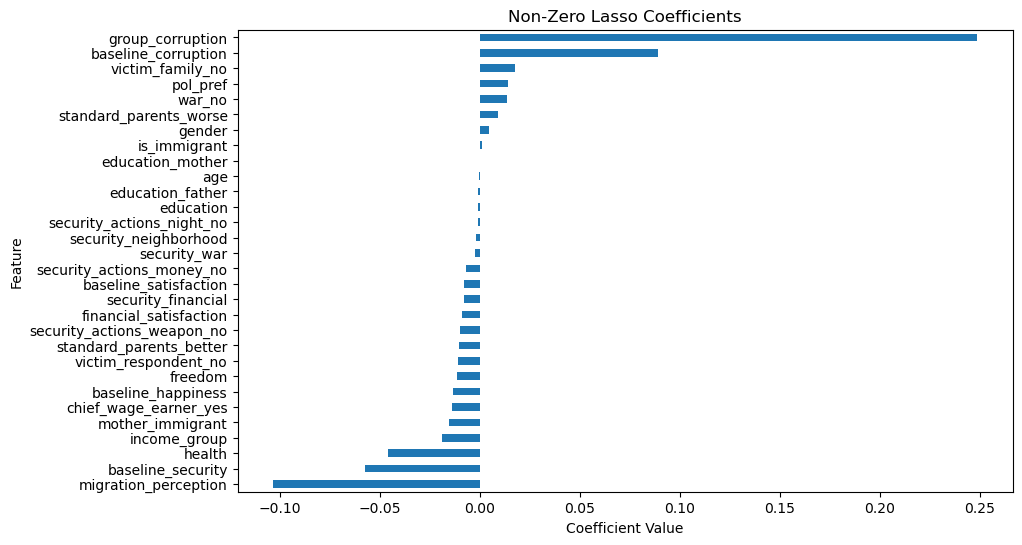

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run LassoCV to find best alpha
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Coefficients
lasso_coefficients = pd.Series(lasso_cv.coef_, index=X.columns)
print("Lasso coefficients:\n", lasso_coefficients)

# R^2 Scores
print(f"Training R^2: {lasso_cv.score(X_train, y_train):.3f}")
print(f"Test R^2: {lasso_cv.score(X_test, y_test):.3f}")

# Plot non-zero coefficients
nonzero_coeffs = lasso_coefficients[lasso_coefficients != 0]
nonzero_coeffs.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Non-Zero Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Fit robust OLS right away

In [14]:
# Get the names of features with non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
X_ols = X[selected_features]

# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X_ols)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                               OLS Regression Results                              
Dep. Variable:     national_distrust_index   R-squared:                       0.339
Model:                                 OLS   Adj. R-squared:                  0.325
Method:                      Least Squares   F-statistic:                     22.19
Date:                      Mi, 15 Jan 2025   Prob (F-statistic):           1.22e-97
Time:                             20:01:44   Log-Likelihood:                 1254.4
No. Observations:                     1490   AIC:                            -2447.
Df Residuals:                         1459   BIC:                            -2282.
Df Model:                               30                                         
Covariance Type:                       HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

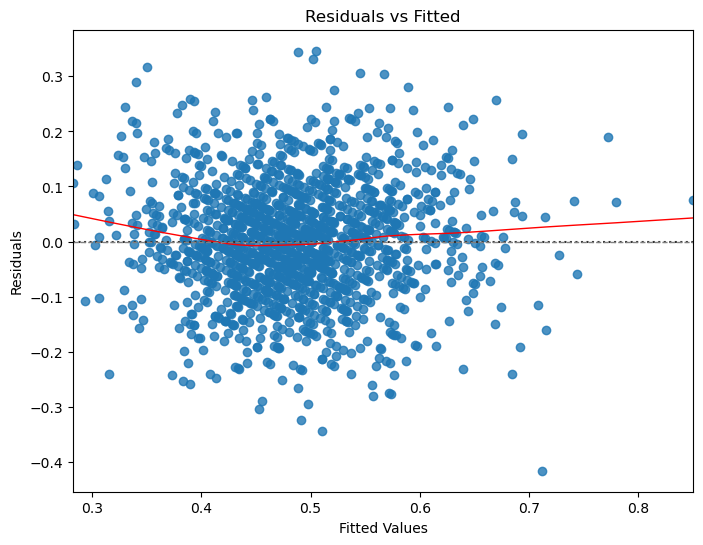

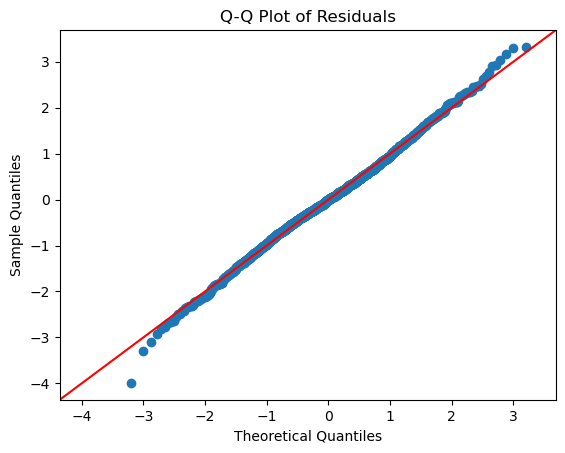

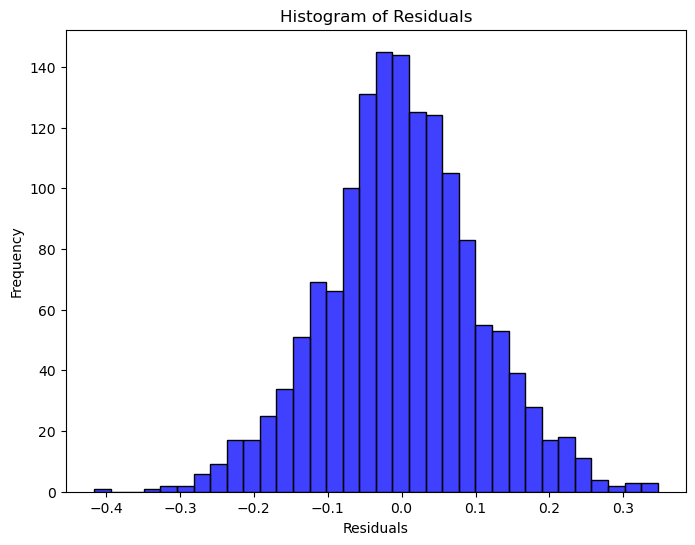

In [15]:
# Residuals from the model
residuals = ols_model_robust.resid

# Predicted values from the model
fitted_values = ols_model_robust.fittedvalues

# 1. Residuals vs. Fitted Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## International distrust

In [16]:
X = df.loc[:, 'baseline_corruption':]
y = df['international_distrust_index']

### LASSO

Best alpha: 0.0005097299792328515
Lasso coefficients:
 baseline_corruption           0.092120
group_corruption              0.230867
migration_perception         -0.108926
migration_positive           -0.014661
migration_negative           -0.002022
pol_pref                     -0.014335
gender                        0.012798
age                           0.000298
mother_immigrant              0.000000
father_immigrant              0.022719
is_immigrant                  0.000000
standard_parents_better      -0.012476
standard_parents_worse        0.008342
baseline_happiness           -0.033595
health                       -0.042945
freedom                       0.000000
baseline_satisfaction         0.000000
financial_satisfaction       -0.000000
hardships_questions          -0.000000
security_actions_money_no    -0.000000
security_actions_night_no    -0.004182
security_actions_weapon_no   -0.008575
victim_respondent_no          0.006022
victim_family_no              0.018953
war_no   

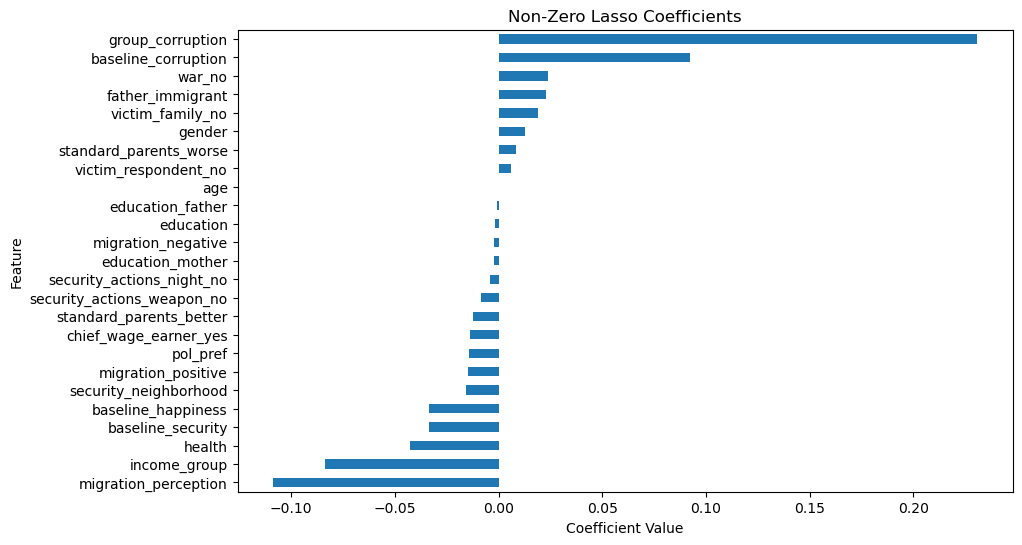

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run LassoCV to find best alpha
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Coefficients
lasso_coefficients = pd.Series(lasso_cv.coef_, index=X.columns)
print("Lasso coefficients:\n", lasso_coefficients)

# R^2 Scores
print(f"Training R^2: {lasso_cv.score(X_train, y_train):.3f}")
print(f"Test R^2: {lasso_cv.score(X_test, y_test):.3f}")

# Plot non-zero coefficients
nonzero_coeffs = lasso_coefficients[lasso_coefficients != 0]
nonzero_coeffs.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Non-Zero Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

## Robust OLS

In [18]:
# Get the names of features with non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
X_ols = X[selected_features]

# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X_ols)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                                 OLS Regression Results                                 
Dep. Variable:     international_distrust_index   R-squared:                       0.222
Model:                                      OLS   Adj. R-squared:                  0.209
Method:                           Least Squares   F-statistic:                     14.24
Date:                           Mi, 15 Jan 2025   Prob (F-statistic):           3.52e-53
Time:                                  20:05:44   Log-Likelihood:                 778.74
No. Observations:                          1490   AIC:                            -1505.
Df Residuals:                              1464   BIC:                            -1368.
Df Model:                                    25                                         
Covariance Type:                            HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

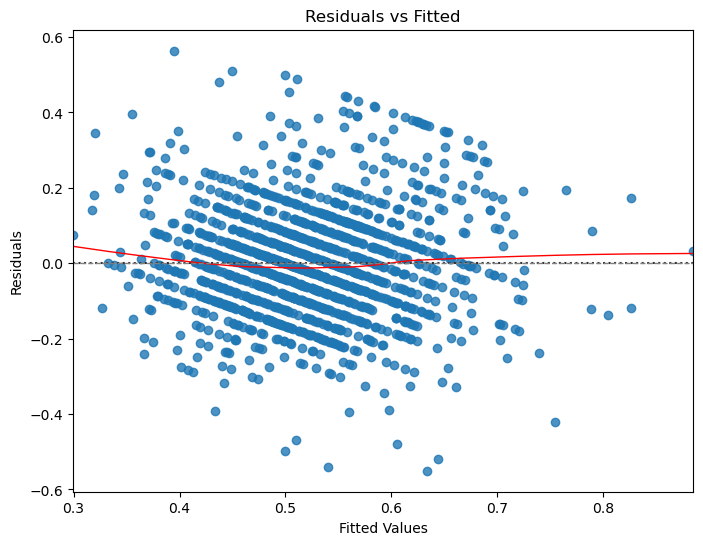

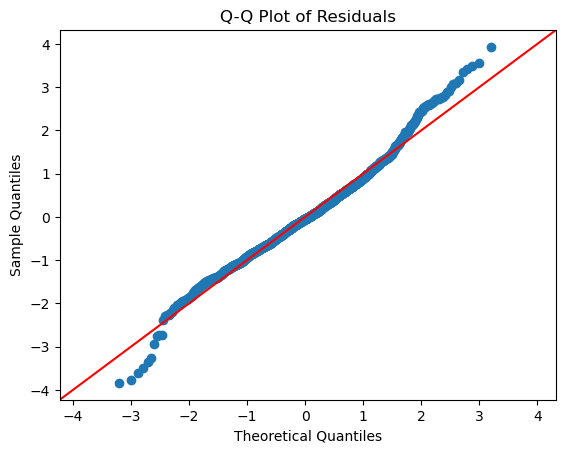

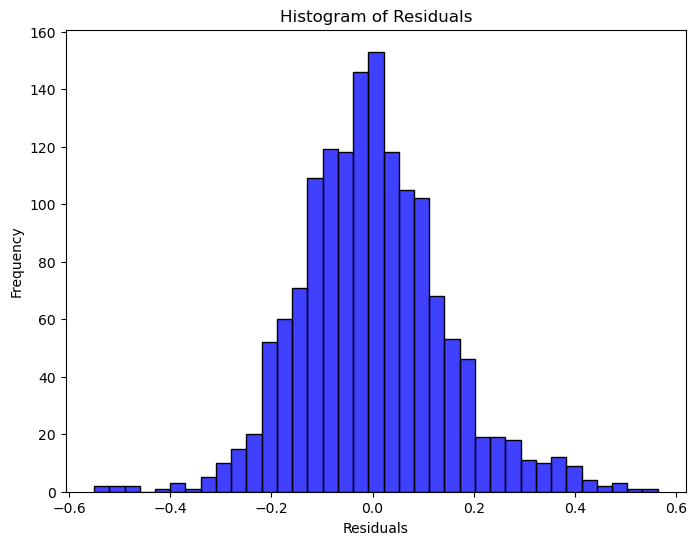

In [19]:
# Residuals from the model
residuals = ols_model_robust.resid

# Predicted values from the model
fitted_values = ols_model_robust.fittedvalues

# 1. Residuals vs. Fitted Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()